In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt





In [2]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

# Print the columns with missing values
# missing_columns = missing_values[missing_values > 0].index.tolist()
# print("Columns with missing values:", missing_columns)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [3]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)

shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)

In [4]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,65.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,255.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,68.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [5]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


Add a 'favourite port', don't think this helped 

In [6]:


# # Count the frequency of each port visit for each vessel
# port_visits = train.groupby(['vesselId', 'portId']).size().reset_index(name='visit_count')

# # Sort by vesselId and visit_count to see the most visited ports
# sorted_port_visits = port_visits.sort_values(by=['vesselId', 'visit_count'], ascending=[True, False])

# favorite_ports = sorted_port_visits.groupby('vesselId').first().reset_index()
# favorite_ports = favorite_ports[['vesselId', 'portId']]
# favorite_ports.columns = ['vesselId', 'favorite_port']

# # Merge favorite_ports with train based on vesselId
# train = train.merge(favorite_ports, on='vesselId', how='left')
# # Display the result
# train.head()

In [7]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'maxSpeed', 'breadth', 'DWT']], on='vesselId', how='left')
train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_maxSpeed_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_maxSpeed_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,maxSpeed,breadth,DWT,vessel_deep_sea
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,NaN,32.00,21214.0,0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,22.5,32.26,18878.0,0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,NaN,32.00,18383.0,0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,NaN,32.00,15199.0,0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,22.4,32.20,18833.0,0


Add if the vessel is on land or in ocean 
- needed to download the fila locally and not through Git 

In [8]:
# ais_ocean_info= pd.read_csv('data/datasets/ais_data.csv', sep=',')
# ais_ocean_info['portId'] = ais_ocean_info['portId'].map(port_id_mapping)
# ais_ocean_info['time'] = pd.to_datetime(ais_ocean_info['time'])
# #
# ais_ocean_info.head()

In [9]:
# # Calculate the number of times each vessel is on land
# train = train.merge(ais_ocean_info[['vesselId', 'time', 'in_ocean']], on=['vesselId', 'time'], how='left')

# vessels_on_land = train[train['in_ocean'] == 0].groupby('vesselId').size().reset_index(name='on_land_count')

# # Create a reverse mapping to get the original vesselId from the integer indices
# reverse_vessel_id_mapping = {idx: vessel_id for vessel_id, idx in vessel_id_mapping.items()}

# # Use this reverse mapping to get the original vesselId for vessels_on_land
# vessels_on_land['original_vesselId'] = vessels_on_land['vesselId'].map(reverse_vessel_id_mapping)

# # Sort the vessels by the number of times they are on land in descending order
# vessels_on_land_sorted = vessels_on_land.sort_values(by='on_land_count', ascending=False)

# # Calculate the total count of each vessel in the original train dataframe
# total_counts = train['vesselId'].value_counts().reset_index()
# total_counts.columns = ['vesselId', 'total_count']

# # Merge total counts with vessels_on_land to calculate percentage
# vessels_on_land_sorted = vessels_on_land_sorted.merge(total_counts, on='vesselId')

# # Calculate the percentage of time each vessel is on land
# vessels_on_land_sorted['on_land_percentage'] = (vessels_on_land_sorted['on_land_count'] / vessels_on_land_sorted['total_count']) * 100

# # Sort the vessels by on_land_percentage in descending order
# vessels_on_land_sorted = vessels_on_land_sorted.sort_values(by='on_land_percentage', ascending=False)

# # Display the top vessels that are most on land by percentage
# print(vessels_on_land_sorted[['original_vesselId', 'on_land_count', 'total_count', 'on_land_percentage']].head())


In [10]:
# import matplotlib.pyplot as plt

# # Plot the distribution of on_land_count
# plt.figure(figsize=(10, 6))
# plt.hist(vessels_on_land_sorted['on_land_percentage'], bins=50, edgecolor='k', alpha=0.7)
# plt.title('Distribution of On Land Count')
# plt.xlabel('On Land Count')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [11]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

### Feature engineering 

In [12]:


def feature_engineering(train):
    train = train.copy()
    features = pd.DataFrame()

    train = train.sort_values(by=['vesselId', 'time'])

    # Add basic columns to features from train
    features['vesselId'] = train['vesselId']
    features['time'] = train['time']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['latitude_port'] = train['latitude_port']
    features['longitude_port'] = train['longitude_port']    
    features['cog'] = train['cog']
    features['DWT'] = train['DWT']

    # Create binary 'under_way' based on navstat (1 if navstat is 0 or 8, otherwise 0)
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)

    # Calculate speed based on time and location differences
    features['speed'] = train.groupby('vesselId').apply(
        lambda x: np.sqrt((x['latitude'].diff()**2 + x['longitude'].diff()**2) / (x['time'].diff().dt.total_seconds()**2))
    ).reset_index(drop=True)

    # Rolling statistics for speed (mean, median)
    features['rolling_speed_mean'] = features.groupby('vesselId')['speed'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    features['rolling_speed_median'] = features.groupby('vesselId')['speed'].transform(lambda x: x.rolling(window=6, min_periods=1).median())
    features['rolling_movement_count'] = features.groupby('vesselId')['under_way'].transform(lambda x: x.rolling(window=6, min_periods=1).sum())

    # Time since last movement
    features['time_since_last_movement'] = train.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)

    # Lag features for the last 3 positions (latitude, longitude, time)
    for i in range(1, 4):
        features[f'latitude_{i}'] = train.groupby('vesselId')['latitude'].shift(i)
        features[f'longitude_{i}'] = train.groupby('vesselId')['longitude'].shift(i)
        features[f'time_{i}'] = train.groupby('vesselId')['time'].diff(i).dt.total_seconds()

    # Adding lat, lon, and time since for the last 5 days
    for i in range(1, 6):
        features[f'last_time_day_{i}'] = train.groupby('vesselId')['time'].shift(i * 24)  # Assuming 24 observations per day
        features[f'time_since_day_{i}'] = (train['time'] - features[f'last_time_day_{i}']).dt.total_seconds()

        # Add the lat/lon from the last five days (shift based on daily intervals)
        features[f'latitude_day_{i}'] = train.groupby('vesselId')['latitude'].shift(i * 24)
        features[f'longitude_day_{i}'] = train.groupby('vesselId')['longitude'].shift(i * 24)

    # Drop the datetime columns (last_time_day_1 to last_time_day_5) because we only need numeric time_since_day_* columns
    features.drop([f'last_time_day_{i}' for i in range(1, 6)], axis=1, inplace=True)

    # Dropping rows with NaN after rolling operations
    features = features.dropna()

    # Split the time column into month, day, hour, and minute
    features['month'] = train['time'].dt.month
    features['day'] = train['time'].dt.day
    features['hour'] = train['time'].dt.hour
    features['minute'] = train['time'].dt.minute

    # Sine and Cosine transformations for COG
    # Handle COG value of 360 as NaN or ignore it
    features['cog'] = features['cog'].replace(360, np.nan)

    # Convert COG to radians for sine and cosine
    features['cog_rad'] = np.radians(features['cog'])

    # Calculate sine and cosine for COG
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])

    # Additional features like vessel type, length, shipping line, etc.
    features['vessel_deep_sea'] = train['vessel_deep_sea']
    features['shippingLineId'] = train['shippingLineId']
    features['length'] = train['length']

    return features

# Test the function
features = feature_engineering(train)
features.head()


C:\Users\ingvi\AppData\Local\Temp\ipykernel_13596\2631780943.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features['speed'] = train.groupby('vesselId').apply(


,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog,DWT,under_way,speed,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,2024-02-05 21:16:16,32.53669,-117.46805,32.684444,-117.161389,248.7,21214.0,1,1.141108e-04,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,2024-02-05 21:36:47,32.53490,-117.47044,32.684444,-117.161389,41.9,21214.0,1,3.367175e-08,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,2024-02-05 21:57:04,32.54160,-117.46490,32.684444,-117.161389,21.9,21214.0,1,1.275335e-04,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,2024-02-05 22:17:14,32.54949,-117.46049,32.684444,-117.161389,19.2,21214.0,1,0.000000e+00,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,2024-02-05 22:38:00,32.55780,-117.45671,32.684444,-117.161389,21.6,21214.0,1,3.274905e-08,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [13]:
features.head()

,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog,DWT,under_way,speed,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,2024-02-05 21:16:16,32.53669,-117.46805,32.684444,-117.161389,248.7,21214.0,1,1.141108e-04,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,2024-02-05 21:36:47,32.53490,-117.47044,32.684444,-117.161389,41.9,21214.0,1,3.367175e-08,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,2024-02-05 21:57:04,32.54160,-117.46490,32.684444,-117.161389,21.9,21214.0,1,1.275335e-04,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,2024-02-05 22:17:14,32.54949,-117.46049,32.684444,-117.161389,19.2,21214.0,1,0.000000e+00,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,2024-02-05 22:38:00,32.55780,-117.45671,32.684444,-117.161389,21.6,21214.0,1,3.274905e-08,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [14]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(features)
last_features.head()


,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog,DWT,under_way,speed,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
0,0,2024-05-01 12:41:57,34.57936,128.99926,35.109444,129.059444,221.5,21214.0,1,7.306813e-05,...,5,1,12,41,3.865904,-0.662620,-0.748956,0,9,199.00
1,1,2024-04-30 10:12:01,1.24460,103.39997,51.498889,-2.712222,305.1,18878.0,1,2.141556e-07,...,4,30,10,12,5.325000,-0.818150,0.575005,0,6,199.97
2,2,2024-05-07 23:59:02,18.13873,-69.74863,18.475278,-69.881111,176.0,18383.0,1,7.936508e-09,...,5,7,23,59,3.071779,0.069756,-0.997564,0,14,199.00
3,3,2024-04-26 13:29:25,41.64055,143.29942,42.988611,144.353611,87.6,15199.0,1,1.419615e-05,...,4,26,13,29,1.528908,0.999123,0.041876,0,5,199.00
4,4,2024-05-07 12:28:39,26.58710,121.27831,27.583000,120.450000,39.1,18833.0,1,7.976980e-05,...,5,7,12,28,0.682424,0.630676,0.776046,0,6,199.95


### Train the model

In [15]:
# # Define features and target
y = features[['latitude', 'longitude']]  
X = features.drop(columns=['latitude', 'longitude', 'time', 'cog']) 

X.head()

,vesselId,latitude_port,longitude_port,DWT,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,time_since_last_movement,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,32.684444,-117.161389,21214.0,1,1.141108e-04,0.000056,5.574396e-05,6.0,1216.0,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,32.684444,-117.161389,21214.0,1,3.367175e-08,0.000044,1.869911e-05,6.0,1231.0,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,32.684444,-117.161389,21214.0,1,1.275335e-04,0.000065,7.514916e-05,6.0,1217.0,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,32.684444,-117.161389,21214.0,1,0.000000e+00,0.000059,5.648372e-05,6.0,1210.0,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,32.684444,-117.161389,21214.0,1,3.274905e-08,0.000040,3.321040e-08,6.0,1246.0,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [16]:
model = RandomForestRegressor(random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300],            # Number of trees in the forest
    'max_depth': [3, 5, None],             # Maximum depth of the tree
    'min_samples_split': [2, 5],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],            # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],      # The number of features to consider when looking for the best split
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)
random_search.fit(X, y)

best_model = random_search.best_estimator_

# Output the best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (negative mean squared error): {-random_search.best_score_}")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
X.head()

,vesselId,latitude_port,longitude_port,DWT,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,time_since_last_movement,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,32.684444,-117.161389,21214.0,1,1.141108e-04,0.000056,5.574396e-05,6.0,1216.0,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,32.684444,-117.161389,21214.0,1,3.367175e-08,0.000044,1.869911e-05,6.0,1231.0,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,32.684444,-117.161389,21214.0,1,1.275335e-04,0.000065,7.514916e-05,6.0,1217.0,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,32.684444,-117.161389,21214.0,1,0.000000e+00,0.000059,5.648372e-05,6.0,1210.0,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,32.684444,-117.161389,21214.0,1,3.274905e-08,0.000040,3.321040e-08,6.0,1246.0,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [18]:

def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last_features for merging
    last_features['year'] = 2024  # Assuming 2024 as the year for the test set
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )
    
    # Drop unnecessary columns from last_features
    last_features = last_features.drop(
        columns=['year', 'month', 'day', 'hour', 'minute']
    ).copy()

    # Add vesselId and time to prepared_test
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # Merge with last_features on vesselId to get historical data
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    # Check the columns after merging
    print(prepared_test.columns)

    # Check if the necessary columns are available
    if 'time_last' not in prepared_test.columns:
        raise KeyError("Column 'time_last' not found in prepared_test DataFrame.")
    
    # Calculate the time difference for time_1 (time since last known position)
    prepared_test['time_1'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Assuming latitude and longitude exist, set them correctly
    prepared_test['latitude_1'] = prepared_test['latitude']
    prepared_test['longitude_1'] = prepared_test['longitude']

    # Drop latitude and longitude after copying into latitude_1 and longitude_1
    prepared_test.drop(columns=['latitude', 'longitude'], inplace=True)

    # Extract temporal features from the test time
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute

    # Drop the time columns after feature extraction
   

    # Add last 5 days features (if they exist in last_features)
    for i in range(1, 6):
        time_day_last_col = f'time_day_{i}_last'
        latitude_day_last_col = f'latitude_day_{i}_last'
        longitude_day_last_col = f'longitude_day_{i}_last'
        
        # Check if the columns exist before assigning
        if time_day_last_col in prepared_test.columns:
            prepared_test[f'time_since_day_{i}'] = (prepared_test['time'] - prepared_test[time_day_last_col]).dt.total_seconds()
        
        if latitude_day_last_col in prepared_test.columns:
            prepared_test[f'latitude_day_{i}'] = prepared_test[latitude_day_last_col]
        
        if longitude_day_last_col in prepared_test.columns:
            prepared_test[f'longitude_day_{i}'] = prepared_test[longitude_day_last_col]

    prepared_test['speed_last_2_hours'] = prepared_test.apply(
        lambda row: (
            haversine(
                last_features.loc[(last_features['vesselId'] == row['vesselId']) & 
                                  (last_features['time'] < row['time']) & 
                                  (last_features['time'] >= row['time'] - pd.Timedelta(hours=2)), 'latitude'].values[0],
                last_features.loc[(last_features['vesselId'] == row['vesselId']) & 
                                  (last_features['time'] < row['time']) & 
                                  (last_features['time'] >= row['time'] - pd.Timedelta(hours=2)), 'longitude'].values[0],
                row['latitude_1'],
                row['longitude_1']
            ) / 2 if not last_features.loc[(last_features['vesselId'] == row['vesselId']) & 
                                            (last_features['time'] < row['time']) & 
                                            (last_features['time'] >= row['time'] - pd.Timedelta(hours=2))].empty else np.nan
        ), axis=1
    )

    # Sine and Cosine transformations for COG
    prepared_test['cog'] = last_features['cog'].replace(360, np.nan)  # Handle unavailable COG
    prepared_test['cog_rad'] = np.radians(prepared_test['cog'])  # Convert to radians
    prepared_test['cog_sin'] = np.sin(prepared_test['cog_rad'])  # Sine transformation
    prepared_test['cog_cos'] = np.cos(prepared_test['cog_rad'])  # Cosine transformation

    prepared_test.drop(columns=['time', 'time_last', 'cog'], inplace=True)
   
    return prepared_test

# Example usage for predictions
test_df = prepare_test_for_predictions(test, last_features)
test_df.head()


Index(['vesselId', 'time', 'time_last', 'latitude', 'longitude',
       'latitude_port', 'longitude_port', 'cog', 'DWT', 'under_way', 'speed',
       'rolling_speed_mean', 'rolling_speed_median', 'rolling_movement_count',
       'time_since_last_movement', 'latitude_1', 'longitude_1', 'time_1',
       'latitude_2', 'longitude_2', 'time_2', 'latitude_3', 'longitude_3',
       'time_3', 'time_since_day_1', 'latitude_day_1', 'longitude_day_1',
       'time_since_day_2', 'latitude_day_2', 'longitude_day_2',
       'time_since_day_3', 'latitude_day_3', 'longitude_day_3',
       'time_since_day_4', 'latitude_day_4', 'longitude_day_4',
       'time_since_day_5', 'latitude_day_5', 'longitude_day_5', 'cog_rad',
       'cog_sin', 'cog_cos', 'vessel_deep_sea', 'shippingLineId', 'length'],
      dtype='object')


,vesselId,latitude_port,longitude_port,DWT,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,time_since_last_movement,...,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length,month,day,hour,minute,speed_last_2_hours
0,412,31.140556,-81.496667,31143.0,0.0,1.832843e-08,0.000005,5.241870e-08,0.0,1256.0,...,-0.662620,-0.748956,1.0,5.0,230.0,5,8,0,3,0.0
1,373,14.808333,120.279444,13238.0,0.0,7.804535e-05,0.000021,3.058126e-08,0.0,1762.0,...,-0.818150,0.575005,0.0,3.0,124.0,5,8,0,6,0.0
2,181,42.098889,11.780833,7150.0,1.0,8.407760e-05,0.000036,1.188834e-05,3.0,1506.0,...,0.069756,-0.997564,0.0,11.0,186.0,5,8,0,10,0.0
3,8,-43.606111,172.716111,13951.0,0.0,7.233601e-05,0.000025,5.377673e-08,0.0,900.0,...,0.999123,0.041876,0.0,6.0,183.0,5,8,0,10,0.0
4,65,48.380556,-4.474167,12325.0,0.0,5.734694e-05,0.000030,1.613756e-07,3.0,1973.0,...,0.630676,0.776046,0.0,1.0,182.0,5,8,0,12,0.0


Filtered vessel data:
     longitude_day_1  latitude_day_1  longitude_day_2  latitude_day_2  \
0          -81.49792        31.14647        -81.08598        30.93523   
143        -81.49792        31.14647        -81.08598        30.93523   
282        -81.49792        31.14647        -81.08598        30.93523   
426        -81.49792        31.14647        -81.08598        30.93523   
551        -81.49792        31.14647        -81.08598        30.93523   

     longitude_day_3  latitude_day_3  longitude_day_4  latitude_day_4  \
0          -81.08664        30.93475        -81.08634        30.93497   
143        -81.08664        30.93475        -81.08634        30.93497   
282        -81.08664        30.93475        -81.08634        30.93497   
426        -81.08664        30.93475        -81.08634        30.93497   
551        -81.08664        30.93475        -81.08634        30.93497   

     longitude_day_5  latitude_day_5  
0           -81.0867         30.9347  
143         -81.0867  

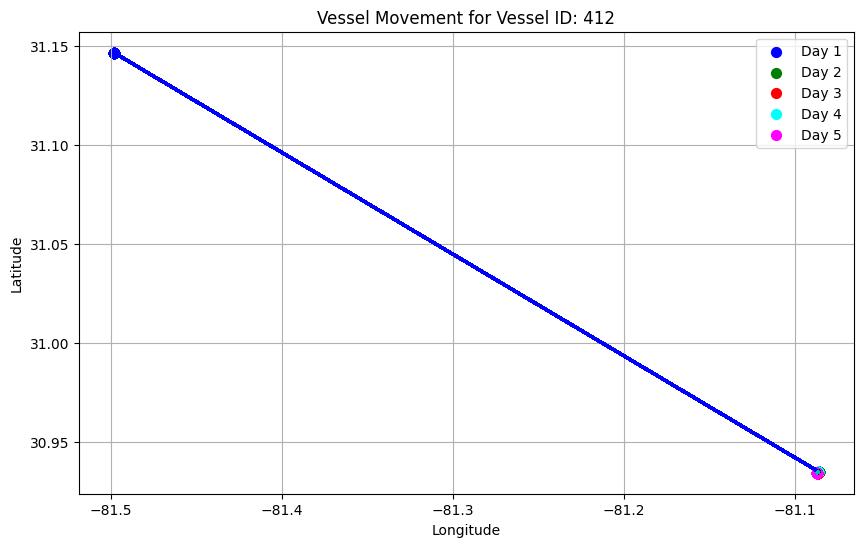

In [19]:
# import matplotlib.pyplot as plt

# Function to plot the vessel movement based on latitude and longitude
def plot_vessel_movement(data, vessel_id):
    # Filter data for the given vessel_id
    vessel_data = data[data['vesselId'] == vessel_id]
    
    # Debug: Check if there is any data for the given vessel_id
    if vessel_data.empty:
        print(f"No data found for vessel ID: {vessel_id}")
        return
    
    # Debug: Print first few rows to check the data
    print("Filtered vessel data:")
    print(vessel_data[['longitude_day_1', 'latitude_day_1', 
                       'longitude_day_2', 'latitude_day_2',
                       'longitude_day_3', 'latitude_day_3',
                       'longitude_day_4', 'latitude_day_4',
                       'longitude_day_5', 'latitude_day_5']].head())

    # Plot the positions for the last 5 days
    plt.figure(figsize=(10, 6))

    # Plotting latitude and longitude for each of the last 5 days
    plt.scatter(vessel_data['longitude_day_1'], vessel_data['latitude_day_1'], color='blue', s=50, label='Day 1')
    plt.scatter(vessel_data['longitude_day_2'], vessel_data['latitude_day_2'], color='green', s=50, label='Day 2')
    plt.scatter(vessel_data['longitude_day_3'], vessel_data['latitude_day_3'], color='red', s=50, label='Day 3')
    plt.scatter(vessel_data['longitude_day_4'], vessel_data['latitude_day_4'], color='cyan', s=50, label='Day 4')
    plt.scatter(vessel_data['longitude_day_5'], vessel_data['latitude_day_5'], color='magenta', s=50, label='Day 5')

    # Connecting lines between the points
    plt.plot([vessel_data['longitude_day_1'], vessel_data['longitude_day_2']],
             [vessel_data['latitude_day_1'], vessel_data['latitude_day_2']], 'b-', linewidth=2)  # Line Day 1 to Day 2

    plt.plot([vessel_data['longitude_day_2'], vessel_data['longitude_day_3']],
             [vessel_data['latitude_day_2'], vessel_data['latitude_day_3']], 'g-', linewidth=2)  # Line Day 2 to Day 3

    plt.plot([vessel_data['longitude_day_3'], vessel_data['longitude_day_4']],
             [vessel_data['latitude_day_3'], vessel_data['latitude_day_4']], 'r-', linewidth=2)  # Line Day 3 to Day 4

    plt.plot([vessel_data['longitude_day_4'], vessel_data['longitude_day_5']],
             [vessel_data['latitude_day_4'], vessel_data['latitude_day_5']], 'c-', linewidth=2)  # Line Day 4 to Day 5

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Vessel Movement for Vessel ID: {vessel_id}')
    
    # Add legend to differentiate between days
    plt.legend(loc='best')
    
    # Show the plot
    plt.grid(True)  # Optional: add grid for better visibility
    plt.show()

# Example call to plot the movement of a specific vessel
plot_vessel_movement(test_df, vessel_id=412)


In [20]:
expected_feature_names = X.columns.tolist()  # Or use list(X.columns) to convert to a list

# Ensure the test DataFrame has all the required columns and in the correct order
test_df = test_df[expected_feature_names]


# Print the final DataFrame structure to ensure it's correct
print("Final test_df structure:")
# test_df = test_df.drop(columns=['vesselId'], errors='ignore')
print(test_df.head())

predictions = best_model.predict(test_df)

# Display predictions
print(predictions)

Final test_df structure:
   vesselId  latitude_port  longitude_port      DWT  under_way         speed  \
0       412      31.140556      -81.496667  31143.0        0.0  1.832843e-08   
1       373      14.808333      120.279444  13238.0        0.0  7.804535e-05   
2       181      42.098889       11.780833   7150.0        1.0  8.407760e-05   
3         8     -43.606111      172.716111  13951.0        0.0  7.233601e-05   
4        65      48.380556       -4.474167  12325.0        0.0  5.734694e-05   

   rolling_speed_mean  rolling_speed_median  rolling_movement_count  \
0            0.000005          5.241870e-08                     0.0   
1            0.000021          3.058126e-08                     0.0   
2            0.000036          1.188834e-05                     3.0   
3            0.000025          5.377673e-08                     0.0   
4            0.000030          1.613756e-07                     3.0   

   time_since_last_movement  ...  month  day  hour  minute   cog_ra

In [21]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

merged_df = pd.merge(test, predictions_df, on='ID', how='left')
merged_df.head()

,ID,vesselId,time,scaling_factor,longitude_predicted,latitude_predicted
0,0,412,2024-05-08 00:03:16,0.3,-81.221001,31.244261
1,1,373,2024-05-08 00:06:17,0.3,120.173126,15.177113
2,2,181,2024-05-08 00:10:02,0.3,11.007548,38.284164
3,3,8,2024-05-08 00:10:34,0.3,173.290329,-43.428032
4,4,65,2024-05-08 00:12:27,0.3,-6.040136,48.462761


   ID  vesselId                time  scaling_factor  longitude_predicted  \
0   0       412 2024-05-08 00:03:16             0.3           -81.221001   
1   1       373 2024-05-08 00:06:17             0.3           120.173126   
2   2       181 2024-05-08 00:10:02             0.3            11.007548   
3   3         8 2024-05-08 00:10:34             0.3           173.290329   
4   4        65 2024-05-08 00:12:27             0.3            -6.040136   

   latitude_predicted  
0           31.244261  
1           15.177113  
2           38.284164  
3          -43.428032  
4           48.462761  
Filtered vessel data:
     longitude_day_1  latitude_day_1  longitude_day_2  latitude_day_2  \
132         -9.74227        43.82987         -2.77258        49.99635   
219         -9.74227        43.82987         -2.77258        49.99635   
367         -9.74227        43.82987         -2.77258        49.99635   
517         -9.74227        43.82987         -2.77258        49.99635   
561         

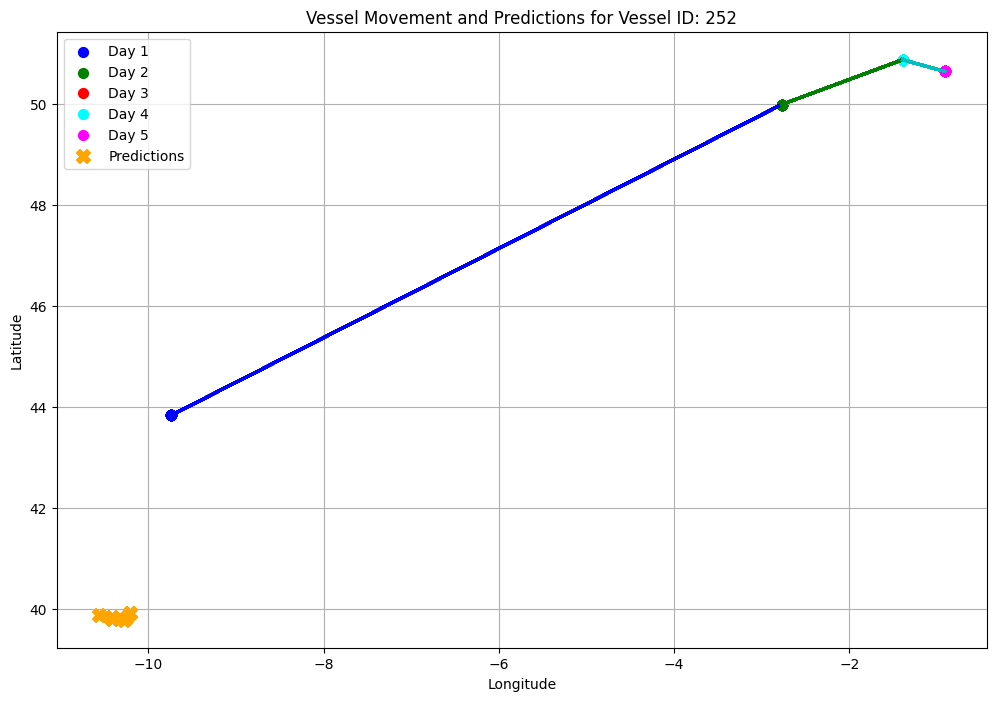

In [22]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = predictions_df.index
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

merged_df = pd.merge(test, predictions_df, on='ID', how='left')
print(merged_df.head())
# Function to plot the vessel movement based on latitude and longitude, including predictions

def plot_vessel_movement_with_predictions(data, predictions, vessel_id):
    # Filter data for the given vessel_id
    vessel_data = data[data['vesselId'] == vessel_id]
    
    # Debug: Check if there is any data for the given vessel_id
    if vessel_data.empty:
        print(f"No data found for vessel ID: {vessel_id}")
        return
    
    # Debug: Print first few rows to check the data
    print("Filtered vessel data:")
    print(vessel_data[['longitude_day_1', 'latitude_day_1', 
                       'longitude_day_2', 'latitude_day_2',
                       'longitude_day_3', 'latitude_day_3',
                       'longitude_day_4', 'latitude_day_4',
                       'longitude_day_5', 'latitude_day_5']].head())
    
    # Debug: Check the type and columns of predictions DataFrame
    print("Predictions DataFrame type:", type(predictions))
    print("Predictions DataFrame columns:", predictions.columns)

    # Ensure vesselId exists in predictions DataFrame
    if 'vesselId' not in predictions.columns:
        print("vesselId column not found in predictions DataFrame.")
        return

    # Filter predictions for the given vessel_id
    pred_data = predictions[predictions['vesselId'] == vessel_id]

    # Plot the positions for the last 5 days
    plt.figure(figsize=(12, 8))

    # Plotting latitude and longitude for each of the last 5 days
    plt.scatter(vessel_data['longitude_day_1'], vessel_data['latitude_day_1'], color='blue', s=50, label='Day 1')
    plt.scatter(vessel_data['longitude_day_2'], vessel_data['latitude_day_2'], color='green', s=50, label='Day 2')
    plt.scatter(vessel_data['longitude_day_3'], vessel_data['latitude_day_3'], color='red', s=50, label='Day 3')
    plt.scatter(vessel_data['longitude_day_4'], vessel_data['latitude_day_4'], color='cyan', s=50, label='Day 4')
    plt.scatter(vessel_data['longitude_day_5'], vessel_data['latitude_day_5'], color='magenta', s=50, label='Day 5')

    # Connecting lines between the points for the last 5 days
    plt.plot([vessel_data['longitude_day_1'], vessel_data['longitude_day_2']],
             [vessel_data['latitude_day_1'], vessel_data['latitude_day_2']], 'b-', linewidth=2)  # Line Day 1 to Day 2

    plt.plot([vessel_data['longitude_day_2'], vessel_data['longitude_day_3']],
             [vessel_data['latitude_day_2'], vessel_data['latitude_day_3']], 'g-', linewidth=2)  # Line Day 2 to Day 3

    plt.plot([vessel_data['longitude_day_3'], vessel_data['longitude_day_4']],
             [vessel_data['latitude_day_3'], vessel_data['latitude_day_4']], 'r-', linewidth=2)  # Line Day 3 to Day 4

    plt.plot([vessel_data['longitude_day_4'], vessel_data['longitude_day_5']],
             [vessel_data['latitude_day_4'], vessel_data['latitude_day_5']], 'c-', linewidth=2)  # Line Day 4 to Day 5

    # Plotting predictions
    if not pred_data.empty:
        plt.scatter(pred_data['longitude_predicted'], pred_data['latitude_predicted'], color='orange', s=100, label='Predictions', marker='X')
    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Vessel Movement and Predictions for Vessel ID: {vessel_id}')
    
    # Add legend to differentiate between days
    plt.legend(loc='best')
    
    # Show the plot
    plt.grid(True)  # Optional: add grid for better visibility
    plt.show()

# Example call to plot the movement of a specific vessel with predictions
plot_vessel_movement_with_predictions(test_df, merged_df, vessel_id=252)

In [23]:
predictions_df.to_csv('data/submissions/predictions_201.csv', index=False)